# Sampler PolyaGamma

In [1]:
# Libraries

import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Here will be some functions for Polya-Gamma Gibbs sampling

# Naive sampler for PG(1, z)
# (based on the finite approximation of infinite sum)
def rpolyagamma_naive(z, n_terms = 100):
    g = np.random.exponential(1, n_terms)  #rexp(n_terms, 1)
    out = 1 / (2*np.pi**2) * sum(g / ( ( np.linspace(1, n_terms, n_terms) - 1/2)**2 + z**2 / (4*np.pi**2) ) )
    #out = 1 / (2*pi**2) * sum(g / ( (1:n_terms - 1/2)**2 + z**2 / (4*pi**2) ) )
    return out
#end function


In [3]:
#FUNCTION: cdf(x) of inverse Normal distribution with parameters mu and lambda
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
def pinversen(x,mu,lambda_):
    #check if x, mu and lambda are positive real numbers
    if ((x<=0)|(mu<=0)|(lambda_<=0)):
        stop("Parameters in pinversen() are not of the correct type")
    #end if

    #assign variables
    sqrt_lambda_over_x = np.sqrt(lambda_/x)
    x_over_mu = x/mu

    #work out the cdf and return it
    cdf = norm.cdf( sqrt_lambda_over_x * (x_over_mu-1.) ) #pnorm(sqrt_lambda_over_x*(x_over_mu-1));
    if (cdf!=1):
        cdf = cdf + np.exp(2*lambda_/mu) * norm.cdf(- sqrt_lambda_over_x * (x_over_mu+1.))
    #end if
    return cdf
#end pinversen

In [4]:
#FUNCTION: Piecewise coefficients
#PARAMETERS:
#Parameter x, nth term, truncate at t
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
def a_n(x,n,t):
    #check if n is positive integer, x is positive real, t is positive real
    if (np.any(x<=0) or (t<=0) or (round(n)!=n) or (n<0)):
        #stop("Parameters in a_n are not of the correct type")
        raise ValueError("Parameters in a_n are not of the correct type")
    #end if
    a = 0
    #for a <= t
    if np.all(x <=t): #int(x<=t)
        a = (np.pi*(n+0.5)*(np.sqrt(2/(np.pi*x)))**3*np.exp(-2*(n+0.5)**2 /x)) # *int(x<=t)
    #for a > t
    else:
        a = a + (np.pi*(n+0.5)*np.exp(-0.5*(n+0.5)**2 *np.pi**2 *x)) # * int(x>t)

    #return a
    return a
#end a_n


In [5]:
#FUNCTION: Generate sample from inverse Normal with parameters (mu, 1) truncated with a max of t
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
def rinversen(mu, t):
      #check if mu and t are positive real
    #if ((mu<=0)|(t<=0)):
        #stop("Parameters in rinversen are not of the correct type")
    if (mu<=0) or (t<=0):
        raise ValueError("Parameters in rinversen are not of the correct type")
    #end if

    #x is the random sample
    x = t;

    #while x is equal or more than t, sample
    while x>=t:
        #for large mu, use chi-squared approximation
        if (mu>t):
            #repeat:
            #assign x, alpha
            E, E_prime = np.random.exponential(1, size=2)
            x = t/(1 + t*E)**2
            alpha = np.exp(-0.5*x / mu**2)
            while np.random.uniform(0,1) > alpha:
                #sample exponential (full details in paper)
                while ( E**2 > 2*E_prime/t ): #E[0]**2 > 2*E[1]/t
                #repeat:
                    E, E_prime = np.random.exponential(1, 2);
                    if (E**2<=2*E_prime/t):
                        #E = E
                        break
                    #end if
                #end repeat

                #assign x, alpha
                x = t/(1+t*E)**2
                alpha = np.exp(-0.5*x/mu**2)
                
                #accept if U(0,1) <= alpha
                if (np.random.uniform(0,1)<=alpha):
                    break
            #end if

        #end repeat
        #end if

        #else for small mu...
        else:
            y = (np.random.normal(0,1))**2;
            x = mu + 0.5*mu*mu*y - 0.5*mu* np.sqrt(4*mu*y + (mu*y)**2)
            if (np.random.uniform(0,1) > mu/(mu+x)):
                x = mu*mu/x
            while x > np.random.uniform(0,1):
                y = np.random.normal(0,1)**2
                x = mu + 0.5 * mu*mu * y - 0.5*mu* np.sqrt(4*mu*y + (mu*y)**2)
                #u = np.random.uniform(0,1)
                if np.random.uniform(0,1) > (mu/ (mu+x)):
                    x = mu*mu / x
            #end if
        #else

        #end while

        #return the sample
    return x
    #end rinverse

In [6]:
#DEBUG FUNCTION: pdf(x) of inverse normal with parameter mu, lambda
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
dinversen = lambda x,mu,lambda_: np.sqrt(lambda_/(2*np.pi*x**3)) * np.exp(-lambda_*(x-mu)**2/(2*mu**2*x))
#end dinversen

#DEBUG FUNCTION: pdf(x|x<t) where x~IG(mu,lambda)
#AUTHOR: SHERMAN IP
#DATE: 15/10/15
def dtruncatedinversen(x,mu,lambda_,t):
    return(dinversen(x,mu,lambda_)/pinversen(t,mu,lambda_))
#end dtruncatedinversen

#DEBUG FUNCTION: plot histogram and pdf of truncated IG(mu,1) at t
#AUTHOR: SHERMAN IP
#DATE: 15/10/15
def testinversen(mu,t):
    x = np.array( [rinversen(mu,t) for i in range(10000)])
    #replicate(10000,rinversen(mu,t));
    #Observeable: the pdf can't be evaluated for mu<0.0029
    x_plot = np.linspace(min(x), max(x), num=100000) #seq(from=min(x), to=max(x),length=100000);
    f_plot = dtruncatedinversen(x_plot, mu,1,t) 
    
    #sapply(x_plot, dtruncatedinversen, mu=mu,lambda=1, t=t);
    _, _, _ = plt.hist(x, density=True) #hist(x,freq=FALSE);
    plt.plot(x_plot, f_plot) #lines(x_plot,f_plot);
    plt.show()
# #end testinversen

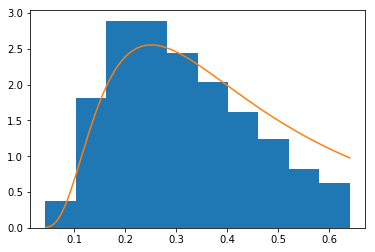

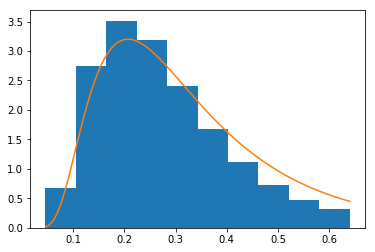

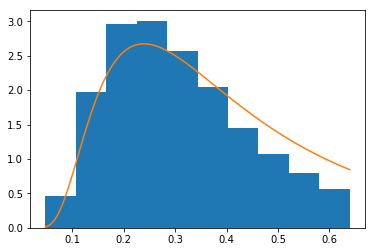

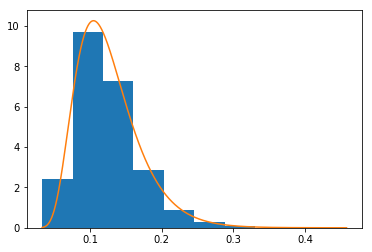

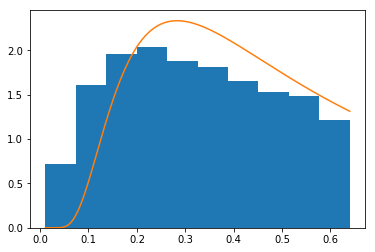

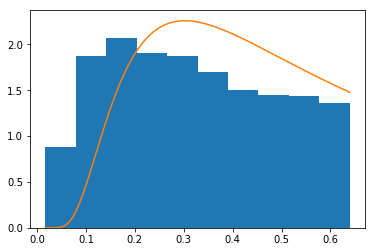

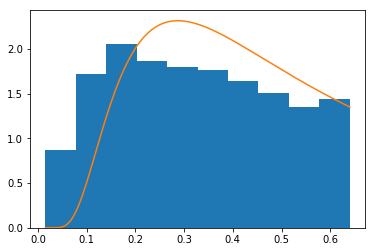

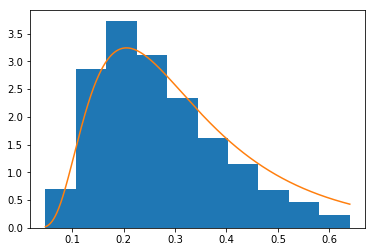

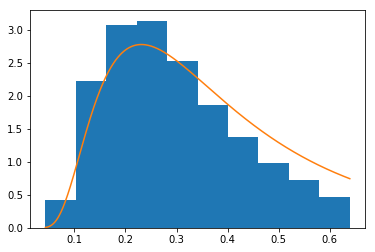

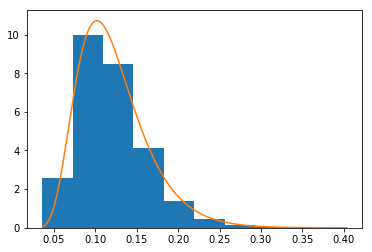

In [32]:
for i in range(10):
    testinversen(np.random.uniform(0,1), 0.64)

In [8]:
## Plot histogram

# # An "interface" to matplotlib.axes.Axes.hist() method
# n, bins, patches = plt.hist(x=d, bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
# maxfreq = n.max()
# # Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [9]:
#FUNCTION: Generate sample from PolyaGamma(a,z) with truncation t
#PARAMETERS: a is an integer, z and t are positive real numbers
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
#NOTES: Fails for high z
def rpolyagamma(a, z, t):
    #check if a is integer, t are positive real numbers
    #if ((a!=round(a))|(a<=0)|(t<=0)):
        #stop("Parameters in rpolyagamma are not of the correct type");
    if ((a!=round(a)) or (a<=0) or (t<=0)):
        raise ValueError("Parameters in rpolyagamma are not of the correct type")
    #end if

    #if a is not 1, ie >1, then add together rpolyagamma sample a times
    if (a!=1):
        x= 0 #assign x
        #a times
        for i in range(a): # i in seq(from=1,to=a)
            #add sample from polyagamma(1,z)
            x = x + rpolyagamma(1,z,t)
        #end for
        #return x
        return x
      #end if

    #else a is 1
    else:
        z = abs(z)/2
        mu = 1/z
        K = np.pi*np.pi/8 + z*z/2
        
        #print('K',K)
        #calculate mixture coefficient
        p = np.pi/(2*K) * np.exp(-K*t)
        q = 2*np.exp(-z) * pinversen(t, mu,lambda_=1.0)
        #        
        r = p/(p+q)
        #if the mixture coefficent is not finite, stop the program
        if not np.isfinite(r): #(!is.finite(r)):
            raise ValueError("Mixture coefficients are not finite in rpolyagamma");
        #end if

        #put in global REJECTION count
        REJECTION = 0;

        #accept-reject sample, repeat until accept
        cond =0
        while cond < 1000:
            #sample x from mixture model

            #probability p/(p+q), sample truncated exp
            if(np.random.uniform(0,1)<r):
                x = t + np.random.exponential(1)/K;
            #end if
            #else sample from inverse n
            else:
                x = rinversen(mu,t);
            #end else

            #get 0th coefficient
            #print('x',x)
            S = a_n(x,0,t);
            y = np.random.uniform(0,1) *S #runif(1)*S;
            #print('S',S, 'y',y)
            n = 0
            cond1 = 0
            while cond1<100: #repeat
                n += 1;
                #for odd n
                if ((n%2)==1):
                    S -= a_n(x,n,t)
                    #if y is smaller than S, accept and return it
                    if (y<S):
                        return x/4, REJECTION #np.array([x/4]).astype(float);
                    #end if
                #end if
                #for even n
                else:
                    S += a_n(x,n,t)
                    cond1 += 1
                    #if y is bigger than S, reject it and increase the global counter
                    if (y>S):
                        REJECTION = REJECTION + 1;
                        break;
                    #end if
                #end else
            #end while repeat
            cond +=1
        #end while repeat
    #end else
#end rpolyagamma

In [10]:
#PLOT FUNCTION
#plot the histogram and curve of samples and pdf of polya gamma used for the report
def plotHistogramPolyaGamma():
    #par(mfrow=c(2,3))
    plt.figure(figsize = (2,3))
    testpolyagamma(0.1,0.64)
    testpolyagamma(1,0.64)
    testpolyagamma(10,0.64)
    testpolyagammanaive(10,2)
    testpolyagammanaive(10,10)
    testpolyagammanaive(10,100)
    #end plotHistogramPolyaGamma

In [11]:
#DEBUG FUNCTION: plot histogram and pdf of PG(1,z) with truncation t
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
def testpolyagamma(z,t):
    x = []
    for i in range(10000):
        xi, _ = rpolyagamma(1,z,t)
        x.append( xi )
    x = np.array(x)
    #np.repeat(rpolyagamma(1,z,t), 10000)#replicate(10000,rpolyagamma(1,z,t))
    
    #Observeable: the pdf can't be evaluated for mu<0.0029
    x_plot = np.linspace(min(x), max(x), num=1000) #seq(from=min(x),to=max(x),length=1000)
    f_plot = dpolyagamma(x_plot,z,t) #sapply(x_plot,dpolyagamma,z=z,t=t)
    
    #hist(x,freq=FALSE,main=paste("Proposed PG(1,",toString(z),") sampler",sep=""),xlim=c(0,max(x)), ylim=c(0, max(f_plot)*1.2),breaks=20);
    plt.figure(figsize = (2,3))
    plt.hist(x, range= (x.min(), x.max()), density=True)
    #plt.bar(range(len(x)), x)
    plt.plot(x_plot,f_plot) #lines(x_plot,f_plot)
    
    #end testinversen

In [12]:
#DEBUG FUNCTION: plot histogram and pdf of PG(1,z) using the naive sampler
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
def testpolyagammanaive(z,n):
    x = np.array( [rpolyagamma_naive(z, n_terms=n) for i in range(10000)])
    #replicate(10000,rpolyagamma_naive(z,n_terms = n))
    #Observeable: the pdf can't be evaluated for mu<0.0029
    x_plot = np.linspace(min(x), max(x), num=1000) #seq(from=min(x),to=max(x),length=1000)
    f_plot = dpolyagamma(x_plot,z,t=0.64) #sapply(x_plot,dpolyagamma,z=z,t=t)
    #hist(x,freq=FALSE,main=paste("Naive PG(1,",toString(z),") sampler with ",toString(n)," term(s)",sep=""),xlim=c(0,max(x)),ylim=c(0, max(f_plot)*1.2),breaks=20);
    #lines(x_plot,f_plot)
    plt.figure(figsize=(2,3))
    #plt.bar(range(len(x_plot)), x_plot)
    plt.hist(x, range=(x.min(), x.max()), density=True)
    plt.plot(x_plot, f_plot) #lines(x_plot,f_plot)
    #end testinversen

In [13]:
#DEBUG FUNCTION: pdf of PG(1,z) at x and truncation point t
#AUTHOR: Awa SAMAKE
#DATE: 25/07/19
def dpolyagamma(x,z,t):
    pdf = 0;
    #use the first 100 terms in infinite sum
    for i in range(100): #0:100
        pdf = pdf + (-1)**i* a_n(4*x, i, t);
    #end for
    return (4*np.cosh(z/2)*np.exp(-z*z*4*x/8)*pdf).astype(float)
    #end dpolyagamma

#EXPERIMENT FUNCTION: investegate the rejection rate of the polyagamma sampler
#PARAMETERS: sample PG(1,10^b_exp_array) n times
def rejectionPolyaGamma(b_exp_array, n):
    #check if b is a vector and n is a positive integer
    if (not isinstance(b_exp_array, np.ndarray) | (n!=round(n)) | (n<=0) ):#( (!is.vector(b_exp_array)) | (n!=round(n)) | (n<=0) ):
        raise ValueError("Paramters in rejectionPolyaGamma are not of the correct type")
  
    rejection_matrix = np.zeros((n, b_exp_array.shape[0]))
    #matrix(0,nrow=n,ncol=length(b_exp_array))
    
    for j in range(b_exp_array.shape[0]):
        b = 10**(b_exp_array[j]);
        for i in range(n): # i in 1:n
            _ , REJECTION = rpolyagamma(1,b,0.64)
            rejection_matrix[i,j] = REJECTION
        #end for
    #end for

    #plot the training and testing error
    #boxplot(rejection_matrix,names=paste("10E",sapply(b_exp_array,toString),sep=""),xlab="b",ylab="Number of rejection");
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))
    # Create an axes instance
    ax = fig.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(rejection_matrix)
    # Save the figure
    #fig.savefig('fig1.png', bbox_inches='tight')
    
    mean = np.mean(rejection_matrix, axis=0) #colMeans(rejection_matrix);
    #errbar(b_exp_array, mean, apply(rejection_matrix,2,min), apply(rejection_matrix,2,max));
    plt.errorbar(b_exp_array, mean)

#end rejectionPolyaGamma


<Figure size 144x216 with 0 Axes>

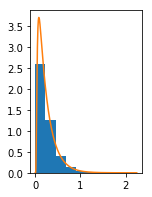

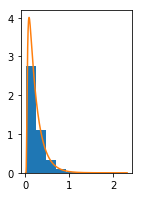

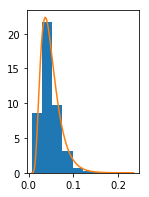

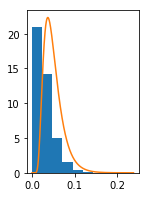

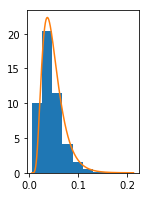

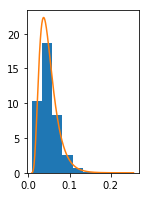

In [14]:
plotHistogramPolyaGamma()

In [15]:
# Generate parameter vector beta from a multivariate normal
# beta ~ N(m, V), see details in the paper
def generate_mv_normal(w, y, X, b, Binv):
    X = X.astype(float)
    Binv = Binv.astype(float)
    w = (w.astype(np.float))
    #w.astype(np.float) #(w.astype(float)).reshape(-1,1)
    temp = X.T @ (w.reshape(-1,1) * X) + Binv #t(X) %*% (w * X) + Binv
    kappa = y - 0.5
    #V = np.linalg.inv( temp) # chol2inv(chol(temp))
    V = np.linalg.inv( np.linalg.cholesky(temp).T @ np.linalg.cholesky(temp))
    
    m = V @ ( X.T.dot(kappa).ravel() + Binv.dot(b)) #as.vector(X.T @ kappa + Binv %*% b)
    
    #print('m',m, 'V',V)
    # now generate beta ~ mvNorm(m, V)
    #beta = np.random.multivariate_normal(m, np.linalg.cholesky(V))
    beta = m + (np.linalg.cholesky(V)).T @ np.random.multivariate_normal(np.zeros(b.shape[0]), np.identity(b.shape[0])) # m + t(chol(V)) %*% rnorm(length(b))
    return beta
    

# Check whether the user has provided arguments
# with matching dimensionalities
def check_dimensions(y, X, b, B):
    if not isinstance(y, np.ndarray):
        raise ValueError("y must be a vector")
    if not isinstance(b, np.ndarray):
        raise ValueError("b must be a vector")
    if not isinstance(X, np.ndarray):
        raise ValueError("X must be a matrix")
    if not isinstance(B, np.ndarray):
        raise ValueError("B must be a matrix")
    if y.shape[0] != X.shape[0]:
        raise ValueError("nrow(X) must equal length(y)")
    if b.shape[0] != X.shape[1]:
        raise ValueError("ncol(X) must equal length(b)")
    
#' Gibbs two-step sampling procedure
#' for parameter vector beta and the latent Polya-Gamma variables
#'
#' @param y binary vector of observations
#' @param X design matrix of covariates
#' @param lambda The diagonal element of the precision matrix of the prior distribution (see also parameter B)
#' @param b The prior mean of the prior distribution. Defaults to a vector of zeros.
#' @param B The prior precision of the prior distribution. Defaults to lambda * identity.
#' @param n_iter The total number of iterations in the MCMC chain
#' @param naive Should the naive approximation be used to generate the Polya-Gamma distribution
#' @param naive_n_terms If the naive approximation is used, then this specifies number of terms in the finite sum.
#' @param t The parameter in the accept-reject algorithm for sampling from Polya-Gamma distribution (see paper for details).
#'
#' @return list containing the MCMC samples from the posterior distribution of beta
#' @examples
#' data = generate_from_simple_logistic_model(n=100)
#' obj = gibbs_sampler(data$y, data$X, lambda=0.001, n_iter_total=100, burn_in=50)
#' plot(obj)
#' @export gibbs_sampler
#'

def gibbs_sampler(y, X, lambda_ = 0.0001, b=0, B=0, n_iter_total = 200, burn_in = 100, naive = False, 
                  naive_n_terms = 100, t = 0.64):
#(y, X, lambda_ = 0.0001, b=rep(0, ncol(X)), B=lambda_*diag(ncol(X)), n_iter_total = 200, burn_in = 100, naive = FALSE, naive_n_terms = 100, t = 0.64)
    # Check if everything is OK with dimensions
    b = np.zeros(X.shape[1]) #np.repeat(0, X.shape[1])
    B = lambda_*np.identity(X.shape[1])
    
    
    check_dimensions(y, X, b, B)

    # number of parameters
    m = X.shape[1] #ncol(X)
    # number of data points
    n = X.shape[0] #nrow(X)
    # Starting values for beta; initialise w
    beta = b
    w = np.zeros(n) #np.repeat('NA', n)
    
    # Store the values of all betas and all w
    beta_all = np.zeros((n_iter_total, m)) # matrix(0, n_iter_total, m)
    w_all = np.zeros((n_iter_total, n)) # matrix(0, n_iter_total, n)

    # initialise progressbar
    #pb = txtProgressBar(min = 0, max = n_iter_total, initial = 0)

    for k in range(n_iter_total): # 1:n_iter_total
        # draw elements of w from PG
        #w = []
        for i in range(n): #1:n
            psi = X[i,:] @ beta #.astype(float) 
            #print('psi',psi,'X', X[i])
            if naive: 
                w[i] = rpolyagamma_naive(psi, naive_n_terms) 
                #w.append(np.float(rpolyagamma_naive(psi, naive_n_terms)) )
            else: 
                #print((rpolyagamma(1, psi, t)))
                w[i], _ = rpolyagamma(1, psi, t)
                
        # draw beta from a multivariate normal
        #print('w',w)
        beta = generate_mv_normal(w, y, X, b, B)
        #print('beta', beta)
        beta_all[k, :] = beta
        
        w_all[k] = w
        #if(k%50==0) setTxtProgressBar(pb, k)
  
    #close(pb)
    selected_ind = np.arange((burn_in+1), n_iter_total, 1) # (burn_in+1):n_iter_total
    out = {"beta": beta_all[selected_ind, :], "w": w_all[selected_ind, :], "burn_in": burn_in }
    #class(out) = "PG"
    return out

In [16]:
# w = np.random.uniform(0,1,10)
# Binv = np.identity(2)
# dat = generate_from_simple_logistic_model(100)
# b = np.zeros(2)
# xs = np.zeros((1000,2))
# for i in range(1000):
#     dat = generate_from_simple_logistic_model(10)
#     xs[i] = generate_mv_normal(w, dat['y'], dat['X'], b, Binv)

# xs0 = np.sort(xs[:,0])
# plt.plot(xs0, norm.pdf(xs0))

In [40]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

#' Simulate data from a simple logistic model
#' @export
def generate_from_simple_logistic_model(n=1000):
    x = np.random.normal(0,1, size=n).reshape(-1,1) #rnorm(n)
    X = np.concatenate((np.ones(n).reshape(-1,1), x), axis=1) # cbind(1, x)
    y = np.random.binomial(1, logistic(1 + 1*x)) # rbinom(n, 1, logistic(1 + 1*x))
    return {"X": X, "y": y}

data = generate_from_simple_logistic_model(1000)
obj = gibbs_sampler(data['y'], data['X'], b=np.repeat(0, 2), B=10*np.identity(data['X'].shape[1]), naive_n_terms=500)
# # obj = gibbs_sampler(data$y, data$X, b=rep(0, 2), B=10*diag(2), 500)


/home/awa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


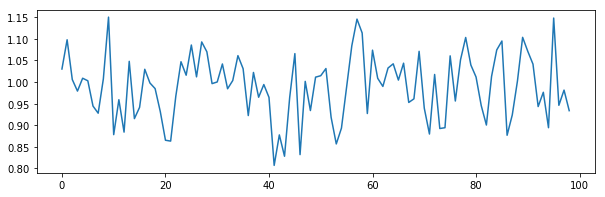

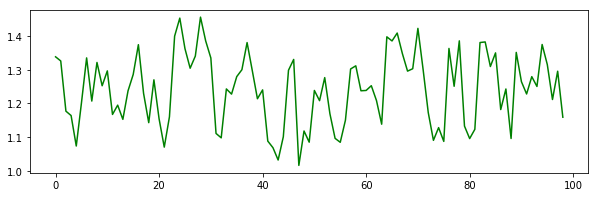

In [41]:
plt.figure(figsize=(10,3))

plt.plot(obj['beta'][:,0])
plt.show()

plt.figure(figsize=(10,3))
plt.plot(obj['beta'][:,1], 'g')


In [43]:
# obj['beta']

In [20]:
naive_out = gibbs_sampler(data['y'], data['X'], b=np.repeat(0, 2), B=10*np.identity(data['X'].shape[1]), naive=True,n_iter_total=500)

In [21]:
# naive_out['beta']

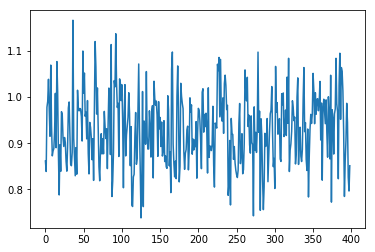

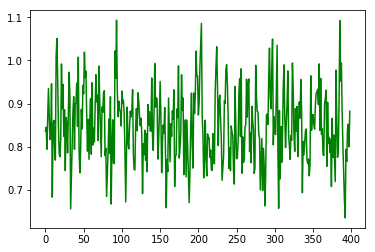

In [22]:
plt.plot(naive_out['beta'][:,0])
plt.show()
plt.plot(naive_out['beta'][:,1],'g')

In [23]:
#' Print a summary of the MCMC chains
#'
#' @export
def print_PG(obj):
    beta = obj['beta']
    posterior_mean = round(np.mean(beta, axis=0), 3) #round(colMeans(beta), 3)
    posterior_sd = round(np.std(beta, axis=0), 3)#round(apply(beta, 2, sd), 3)
    s = "
    MCMC sample from the posterior distribution of beta.
    Chain length: %d (with %d burn-in removed).
    Number of parameters: %d.
    Posterior means: %s.
    Posterior standard deviations: %s.
    "
    cat(sprintf(s,
              nrow(beta),
              obj['burn_in'],
              ncol(beta),
              paste(posterior_mean, collapse=", "),
              paste(posterior_sd, collapse=", ") )
       )


#' Traceplot and autocorrelation plot for the beta chain
#' @param which_parameters Vector of indexes which components of beta vector should be plotted.
#'
#' @export
def plot_PG(obj, which_parameters = np.arange(1, (obj['beta']).shape[1], 1) ):
    X = obj['beta'][, which_parameters, drop=FALSE]

    layout_mat = create_layout_matrix(ncol(X))
    layout(layout_mat)
    for j in range(X.shape[1]):
        x = X[:, j]
        # traceplot
        plt.plot(x) #(x, type="l")
        # autocorrelation plot
        acf(x, main="")
  
    # restore layout to default
    #layout(1)


create_layout_matrix = function(i){
  col1 = seq(1, 2*i, 2)
  col2 = col1
  col3 = col1 + 1
  return(cbind(col1, col2, col3))
}

SyntaxError: EOL while scanning string literal (<ipython-input-23-f5071d35dc24>, line 8)